In [1]:
from sklearn import model_selection
from sklearn import metrics
import os
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from sklearn import model_selection
from sklearn.ensemble import IsolationForest
import seaborn as sns

# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')

In [3]:
os.listdir(inp_dir)

['MatrixDataClean.csv', 'SampleMetaDataClean.csv', 'FeatMetaDataClean.csv']

In [4]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [5]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta.head()

,Unnamed: 0,Unnamed: 0.1,6,study,Study No. (From VG sheet (V-*) from SB sheet (S-*)),Title of Paper,Author (year),Journal,Study Accession,Sample Accession or Sample ID,...,Alcohol Consumption (Yes/No),Diet1,Intervention for study (Diet),Intervention for study (medication),Sequencing Platform,Library layout (SINGLE/PAIRED),Read count after Quality control,Healthy,age_group,age_category
0,0,0,SAMEA104142287,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142287,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,43356775.0,Unhealthy,40-50,adult
1,1,1,SAMEA104142288,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142288,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,41073871.0,Unhealthy,70-80,senior
2,2,2,SAMEA104142293,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142293,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,40199673.0,Unhealthy,70-80,senior
3,3,3,SAMEA104142291,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142291,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,31054158.0,Unhealthy,40-50,adult
4,4,4,SAMEA104142284,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142284,...,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,36081150.0,Unhealthy,60-70,senior


In [6]:
filter_indices = SampleMeta["Phenotype"].isin(['ACVD', 'CRC', 'Crohns disease', 'Healthy'])
SampleMeta = SampleMeta[ filter_indices ]
SampleMeta.shape
MatrixData = MatrixData[ filter_indices ]
MatrixData.shape

(3153, 903)

In [7]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


# Define and Train Model

In [41]:
# random seed here deals with model initialization
clf = IsolationForest(bootstrap=True)
param_grid = {'n_estimators': [50, 100, 150 ],
             'max_features': [50, 100, 150, 300]}
model = model_selection.GridSearchCV(clf, param_grid, scoring = metrics.make_scorer(metrics.balanced_accuracy_score), cv = 5)
MyTrainer = Trainer(model = model, scale_X = True, use_pca = False)
# random seed used in class definition is not used in final output models
MyTrainTester = TrainTester(MyTrainer, metrics.balanced_accuracy_score)
# note that random seed here affects sequence of seeds passed to making new TrainTester objects
# using LRTrainTester as template. Thus, you have all settings but seed affecting sample split
# across all data splits
n_splits = 5
MyMultiTrainTester = MultiTrainTester(MyTrainTester, numpy_rand_seed = 42, n_splits = n_splits)

In [42]:
y = SampleMeta['Healthy'].to_numpy().astype('str') == 'Healthy'
y = y.astype('int64')

In [43]:
MyMultiTrainTester.train(MatrixData, y)

Running for split 1 of 5
Running for split 2 of 5
Running for split 3 of 5
Running for split 4 of 5
Running for split 5 of 5


In [44]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.835448,train
1,0.840999,train
2,0.419675,train
3,0.838224,train
4,0.836638,train
0,0.838352,test
1,0.816165,test
2,0.824089,test
3,0.827258,test
4,0.833597,test


<AxesSubplot:xlabel='stage', ylabel='score'>

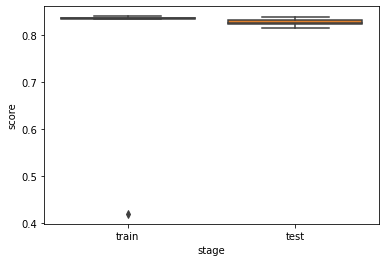

In [45]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

In [46]:
FinalModel = MyMultiTrainTester.TrainerList[0]

In [47]:
FinalModel.model.best_estimator_

IsolationForest(bootstrap=True, max_features=50, n_estimators=50)

In [48]:
isoutlier = pd.DataFrame(MyMultiTrainTester.y_train_pred[0], index=MyMultiTrainTester.y_train[0], columns=["is_inlier"])

In [49]:
isoutlier = isoutlier.reset_index(level=0)

In [50]:
isoutlier.value_counts()

index  is_inlier
1      1            2107
0      1             415
dtype: int64

In [63]:
np.unique(MyMultiTrainTester.y_train_pred[2])
np.unique(np.where(MyMultiTrainTester.y_train_pred[0] == 1, 1, 0))

array([0, 1])